# Grow Banana then Burn

In [53]:
from osgeo import gdal
import rasterio
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import ogr, osr

- Tubbs Fire (Santa Rosa) Landscape 

In [54]:
# Open the Landfire landscape file using gdal
ds = gdal.Open('landscape_lcp/Landscape_1.lcp')

In [55]:
# The total number of rasters (layers) from the landscape file
ds.RasterCount

8

In [56]:
# Get geoSpatial projection Information
ds.GetProjectionRef()

'PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [57]:
# The meta data for the whole landscape
ds.GetMetadata()

{'DESCRIPTION': '', 'LATITUDE': '38', 'LINEAR_UNIT': 'Meters'}

In [58]:
# get raster georeference info
ds.GetGeoTransform()

(-2293725.0, 30.0, 0.0, 2062245.0, 0.0, -30.0)

In [59]:
# Get metadata for raster 4
ds.GetRasterBand(4).GetMetadata()

{'FUEL_MODEL_FILE': 'D:\\scratch\\dist\\lf16285728\\us_200lcp40\\output\\rastert_fuel1.txt',
 'FUEL_MODEL_MAX': '202',
 'FUEL_MODEL_MIN': '91',
 'FUEL_MODEL_NUM_CLASSES': '27',
 'FUEL_MODEL_OPTION': '0',
 'FUEL_MODEL_OPTION_DESC': 'no custom models AND no conversion file needed',
 'FUEL_MODEL_VALUES': '91,93,98,99,101,102,103,121,122,141,142,145,147,161,162,163,165,181,182,183,184,185,186,187,188,189,202',
 'STATISTICS_MAXIMUM': '202',
 'STATISTICS_MEAN': '134.81863926835',
 'STATISTICS_MINIMUM': '91',
 'STATISTICS_STDDEV': '37.212480000173',
 'STATISTICS_VALID_PERCENT': '100'}

In [60]:
# Get layer 4 where specifies the Fuel Model
# Fuel Model classifies the pixel area burnability
fuel_model_raster = np.array(ds.GetRasterBand(4).ReadAsArray())

In [61]:
# Fuel Model Raster Displat function
def plot_raster(raster):
    plt.imshow(raster)
    plt.colorbar()
    plt.title('Overview - Band 4 {}'.format(raster.shape))
    plt.xlabel('Column #')
    plt.ylabel('Row #')

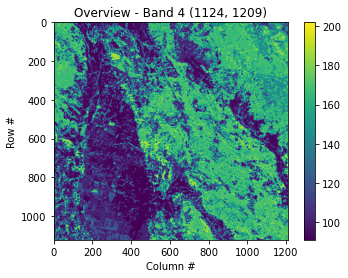

In [62]:
plot_raster(fuel_model_raster)

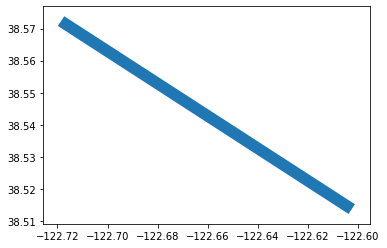

In [63]:
# 200 meters wide buffer created in ArcMAP beforehand
buffer_200 = gpd.read_file("200_buffer/TL2_200_buffer.shp")
buffer_200.plot()

- Changing the buffer

In [64]:
def zonal_buffer(rasters, buffer, target_value):
    #Open landscape raster data which is lcp
    rasters = gdal.Open(rasters)
    
    #Open buffer data that is a shape file
    driver = ogr.GetDriverByName('ESRI Shapefile')
    shp = driver.Open(buffer)
    lyr = shp.GetLayer()
    
    # get raster georeference info
    transform = rasters.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = transform[5]
    
    # reproject geometry to same projection as raster
    sourceSR = lyr.GetSpatialRef()
    targetSR = osr.SpatialReference()
    targetSR.ImportFromWkt(rasters.GetProjectionRef())
    coordTrans = osr.CoordinateTransformation(sourceSR,targetSR)
    feat = lyr.GetNextFeature()
    geom = feat.GetGeometryRef()
    geom.Transform(coordTrans)
    
    # Get extent of geometry
    ring = geom.GetGeometryRef(0)
    numpoints = ring.GetPointCount()
    pointsX = []; pointsY = []
    for p in range(numpoints):
            lon, lat, z = ring.GetPoint(p)
            pointsX.append(lon)
            pointsY.append(lat)
    xmin = min(pointsX)
    xmax = max(pointsX)
    ymin = min(pointsY)
    ymax = max(pointsY)
   
    # Specify offset and rows and columns to read
    xoff = int((xmin - xOrigin)/pixelWidth)
    yoff = int((yOrigin - ymax)/pixelWidth)
    xcount = int((xmax - xmin)/pixelWidth)+1
    ycount = int((ymax - ymin)/pixelWidth)+1
    
    # get the fuel model
    banddataraster = rasters.GetRasterBand(4).ReadAsArray().astype(numpy.float)
    
    # create memory target raster
    target_ds = gdal.GetDriverByName('MEM').Create('', banddataraster.shape[1], banddataraster.shape[0], gdal.GDT_Byte)
    target_ds.SetGeoTransform(transform)
    
    # create for target raster the same projection as for the value raster
    raster_srs = osr.SpatialReference()
    raster_srs.ImportFromWkt(rasters.GetProjectionRef())
    target_ds.SetProjection(raster_srs.ExportToWkt())
    # rasterize zone polygon to raster
    gdal.RasterizeLayer(target_ds, [1], lyr, burn_values=[1])
    
    # read raster as arrays
    banddataraster = rasters.GetRasterBand(4)
    dataraster = banddataraster.ReadAsArray()

    bandmask = target_ds.GetRasterBand(1)
    datamask = bandmask.ReadAsArray()
    
    #show the layer
    dataraster[datamask>0] = target_value

    plot_raster(dataraster)
    
    return dataraster

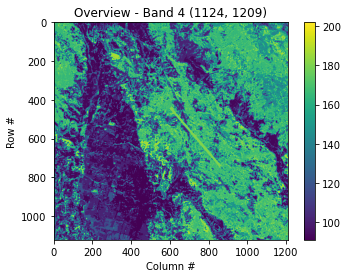

In [65]:
banana_buffer_fm = zonal_buffer('landscape_lcp/Landscape_1.lcp', "200_buffer/TL2_200_buffer.shp", 181)

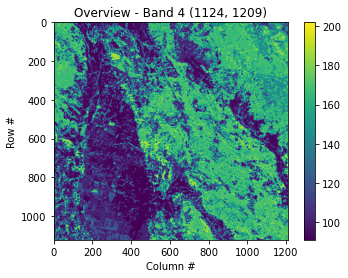

In [66]:
# Get the Fuel Model display again for comparison
plot_raster(fuel_model_raster)

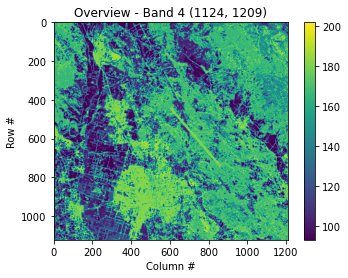

In [41]:
# NB1(urban area) == 91, TL2 == 182(TL2 is a new fuel type)
banana_buffer_fm[banana_buffer_fm == 91] = 182
plot_raster(banana_buffer_fm)

- Creating the new landscape file after modification

In [67]:
mem_drv = gdal.GetDriverByName('MEM')
lcp_drv = gdal.GetDriverByName('LCP')

In [68]:
src_ds = mem_drv.Create('/vsimem2/', banana_buffer_fm.shape[1], banana_buffer_fm.shape[0], ds.RasterCount, gdal.GDT_Int16)

In [69]:
# Read in all the rasters
for i in range(8):
    #data = [random.randint(0, 100) for i in range(myarray.size)]
    array = ds.GetRasterBand(i+1).ReadAsArray()
    src_ds.GetRasterBand(i+1).WriteRaster(0, 0, array.shape[1], array.shape[0], array.tobytes())

In [70]:
# Read in the modification fuel model raster
src_ds.GetRasterBand(4).WriteRaster(0, 0, banana_buffer_fm.shape[1], banana_buffer_fm.shape[0], banana_buffer_fm.tobytes())

# Other information
co = ['LATITUDE=38', 'LINEAR_UNIT=METER', "ELEVATION_UNIT=METERS", "SLOPE_UNIT=DEGREES", "ASPECT_UNIT=AZIMUTH_DEGREES",
      "CANOPY_COV_UNIT = Categories (0-4)", "CANOPY_HT_UNIT_NAME=Meters x 10", "CBH_UNIT_NAME=Meters x 10", "CBD_UNIT_NAME=kg/m^3 x 100"]
out_name = "200_buffer/buffer_TL2_landscape/presentation.lcp"
lcp_ds = lcp_drv.CreateCopy(out_name, src_ds, False, co)
print("SUCCESS: " + out_name)

SUCCESS: 200_buffer/buffer_TL2_landscape/presentation.lcp
